Para empezar a usar dask:
pip install dask o pip install dask[complete]

In [8]:
import numpy as np
import pandas as pd

import dask
import dask.dataframe as dd
import dask.array as da
import dask.bag as db

# No todos los imports son necesarios, depende del tipo de datos con el que estes trabajando.

## Dask Dataframes
Tenemos disponibles 3 tipos de objetos: Dataframe, Array y Bag. En esta parte solo nos enfocaremos en los dataframes


Un dataframe de Dask se compone de dataframes de pandas

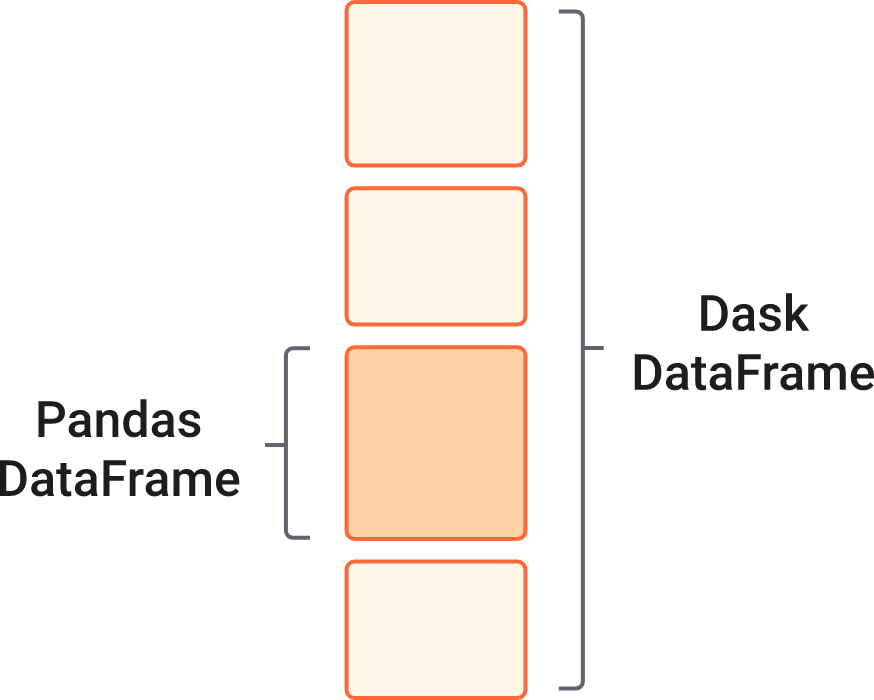

**Usos**
1. Manipulacion de datasets muy grandes, incluso aquellos que exceden la memoria disponible.
2. Aceleracion de los procesos.
3. Distribucion de tareas usando como apoyo pandas.

**Limitaciones**
1. Indexar una columna desordenada.
2. groupby, join --> expensive.
3. Dask no implementa algunas funciones de pandas.

**`Creando el Dataframe`**

In [10]:
# Ejemplo

# Primero creamos un dataframe
index = pd.date_range("2020-07-03", periods=2400, freq="1H")
df = pd.DataFrame({"a": np.arange(2400), "b": list("abcaddbe" * 300)}, index=index)
# df

# Luego, podemos agregar las particiones que queramos al dataframe usando dask
ddf = dd.from_pandas(df, npartitions=10)  # (dataframe a usar, numero de particiones que queremos)
ddf
# ddf.compute()

,a,b
2020-07-03 00:00:00,0,a
2020-07-03 01:00:00,1,b
2020-07-03 02:00:00,2,c
2020-07-03 03:00:00,3,a
2020-07-03 04:00:00,4,d
...,...,...
2020-10-10 19:00:00,2395,a
2020-10-10 20:00:00,2396,d
2020-10-10 21:00:00,2397,d
2020-10-10 22:00:00,2398,b


In [13]:
div = ddf.divisions # nos permite checar los intervalos de cada partición
print(div)

# Accediendo a una partición específica, tiene formato df
p1 = ddf.partitions[1]
p1
# p1.compute()

# Tambien podemos utilizar repartition

(Timestamp('2020-07-03 00:00:00', freq='H'), Timestamp('2020-07-13 00:00:00', freq='H'), Timestamp('2020-07-23 00:00:00', freq='H'), Timestamp('2020-08-02 00:00:00', freq='H'), Timestamp('2020-08-12 00:00:00', freq='H'), Timestamp('2020-08-22 00:00:00', freq='H'), Timestamp('2020-09-01 00:00:00', freq='H'), Timestamp('2020-09-11 00:00:00', freq='H'), Timestamp('2020-09-21 00:00:00', freq='H'), Timestamp('2020-10-01 00:00:00', freq='H'), Timestamp('2020-10-10 23:00:00', freq='H'))


,a,b
npartitions=1,,
2020-07-13,int32,object
2020-07-23,...,...


In [ ]:
# Otro ejemplo, ahora leyendo de un csv file
ddf2 = dd.read_csv('nombre del file.csv', blocksize = 80e6) # 80MB por cada particion
ddf2

**`Indexing`**

Para poder indexar los objetos de dask podemos hacerlo similar a como usualmente lo haciamos en pandas.

Tambien podemos utilizar la funcion set_index() pero con poca frecuencia porque la operacion es muy costosa. Sirve para reducir el tiempo de ejecucion. Similar a SQL.

In [16]:
# ddf.b nos permite ver la estructura de una columna
slice1 = ddf["2020-09-01": "2020-11-01 5:00"]
slice1
# slice1.compute()

# ** Checar **
# ddf = df.set_index('timestamp')  # set the index to make some operations fast

# ddf.loc['2001-01-05':'2001-01-12']  # this is very fast if you have an index
# df.merge(df2, left_index=True, right_index=True)  # this is also very fast

,a,b
2020-09-01 00:00:00,1440,a
2020-09-01 01:00:00,1441,b
2020-09-01 02:00:00,1442,c
2020-09-01 03:00:00,1443,a
2020-09-01 04:00:00,1444,d
...,...,...
2020-10-10 19:00:00,2395,a
2020-10-10 20:00:00,2396,d
2020-10-10 21:00:00,2397,d
2020-10-10 22:00:00,2398,b


**`Persist`**

Often DataFrame workloads look like the following:

1. Load data from files
2. Filter data to a particular subset
3. Shuffle data to set an intelligent index
4. Several complex queries on top of this indexed 


It is often ideal to load, filter, and shuffle data once and keep this result in memory. Afterwards, each of the several complex queries can be based off of this in-memory data rather than have to repeat the full load-filter-shuffle process each time.

**`Computation`**: "Dask is lazily evaluated"

In [ ]:
# Cada que tu quieras obtener el resultado de una operacion debes usar .compute()
slice1.compute()

df = dd.read_csv('s3://bucket/path/to/*.csv')
df = df[df.balance < 0]
df = client.persist(df)

df = df.set_index('timestamp')
df = client.persist(df)

--> df.customer_id.nunique().compute()

18452844

--> df.groupby(df.city).size().compute()

...

**Don't do this**

client.persist(df)  # persist doesn't change the input in-place

**Do this instead**

df = client.persist(df)  # replace your old lazy DataFrame

**`Funciones y Metodos`**

Hay algunas funciones de Dask que coinciden con las existentes de pandas. Para cada funcion solo hay que llamarla y darle .compute() para obtener los resultados.

Algunas funciones : read_csv(), head(), tail(), dropna(), fillna(), persist(), nunique(), pivot_table(), repartition(), pipe(), etc.

In [17]:
# Algunos ejemplos de funciones
ej1 = ddf.a.mean() 
ej1.compute()

# unique similar a distinct
ej2 = ddf.b.unique()
ej2.compute()

# Si tenemos un dataframe muy grande para ahorrarnos tiempo y memoria podemos usar particiones

0    a
1    b
2    c
3    d
4    e
Name: b, dtype: object

Tambien podemos encadenar las funciones como en pandas

In [18]:
res = slice1.a.cumsum() - 42
res.compute()

2020-09-01 00:00:00       1398
2020-09-01 01:00:00       2839
2020-09-01 02:00:00       4281
2020-09-01 03:00:00       5724
2020-09-01 04:00:00       7168
                        ...   
2020-10-10 19:00:00    1833088
2020-10-10 20:00:00    1835484
2020-10-10 21:00:00    1837881
2020-10-10 22:00:00    1840279
2020-10-10 23:00:00    1842678
Freq: H, Name: a, Length: 960, dtype: int32

**`Joins`**

Dask permite:
1. Hacer join de 2 dataframes de dask (single partition)
2. Hacer join de 2 dataframes de dask utilizando los indices
3. Hacer join de un dataframe de dask con un dataframe de pandas

**`Dask does Tasks`**

Siempre tenemos que llamar compute() para poder obtener los resultados. 

Pero tambien podemos usar las funciones .dask y .visualize() para ver las "tasks" que llevara a cabo Dask, ya sea en formato lista o diagrama


In [20]:
ej1.dask # Lista de pasos
# ej1.visualize() # Diagrama

HighLevelGraph with 7 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x18d9310d480>
 0. from_pandas-96367c21b264851aed24fc1821efd34c
 1. getitem-c736fabaaf1fa17adc4514eadaff6465
 2. series-count-chunk-06817e1923bc0c5544af133abfe26928-d50c6b84d0df8f9ec44fb0350847b40c
 3. series-count-agg-06817e1923bc0c5544af133abfe26928
 4. series-sum-chunk-3a41bb6afbe128b21f7c64b5a9541471-7fce84d23c11744f1daf8973ad8d5b28
 5. series-sum-agg-3a41bb6afbe128b21f7c64b5a9541471
 6. series-mean-fc25077e09e8fb543e5fd04ff2a3b9bc-95931f3ca5fc38e8ca77db582e753a1a

Documentacion de todas las funciones de los dataframes : _https://docs.dask.org/en/stable/dataframe-api.html_